# Data Access Notebook for OpenAQ
_by Michelle H Wilkerson_

## Purpose of this Notebook

This notebook was developed as part of NSF Grant XXX to support accessing and processing OpenAQ data for middle and high school classroom activities. It's written to be relatively accessible to beginners, but if you have not interacted with computational notebooks or python before you may find navigating this tool difficult. (Check out the Show Your Work project for a gentle introduction to computational notebooks for educators!)

Our project is focused on supporting data analysis and mechanistic reasoning in science education. In other words, we want students to learn how data provides information about _how scientific mechanisms work_, and how understanding scientific mechanisms can help them to _explain and interpret patterns in data_. This builds on a long history of research on complex systems and agent-based modeling, and more closely connects that work to current expansions of data analysis across subjects.

Here, we are focused on Air Quality as a phenomenon. While most students understand that poor Air Quality can impact health, they may not know that there are many different kinds of air pollution, each caused by different processes and chemicals. These are reflected by different patterns over the course of a day or year

This data tool allows users to connect to OpenAQ, search for air quality data streams in an area of interest, and then identifies the data streams that record observations for _both_ PM2.5 and O3, as two key pollutants impacting air quality and that tend to behave very differently over time. These kinds of datasets can serve as a launch to examining what AQ is and what are its underlying mechanistic and compositional complexities.

You are welcome to modify and adapt this script. You may find the OpenAQ documentation [here](https://docs.openaq.org/) and [here](https://python.openaq.org/) helpful.

## Part I: Connecting with OpenAQ

Before you get started, you will need an OpenAQ API Key. To get one, register for a free account here. Once you're logged in, go to your account settings. At the bottom of the page you will find an API Key. Copy it and set API_KEY in the cell block below to your key. Then, run the cell below to install the openaq API and set your key.

In [ ]:
pip install openaq
API_KEY = "paste your key here"

  Using cached openaq-0.4.0-py3-none-any.whl.metadata (3.3 kB)
Using cached openaq-0.4.0-py3-none-any.whl (51 kB)
Note: you may need to restart the kernel to use updated packages.


Now we'll open your openAQ client. This is what talks to openAQ.

In [19]:
# set up the client to get data from openAQ

from openaq import OpenAQ

client = OpenAQ(api_key=API_KEY)

When we make a request through the client, it will pass data and information back to us in http and JSON formats. These are standard text, but they are not formatted in order to save space. This makes it hard to read and understand the structure of the info we're getting from the API. So the cell below loads some helper tools to process and "pretty print" the information we get from OpenAQ. 

In [26]:
# import some helpful tools for looking at data

import json # to handle JSON
from pprint import pprint # pretty print JSON and other structures

We are going to focus on datasets that report levels of PM2.5 and O3 for the same location. But, you might be interested in accessing data about other pollutants. The cell below lists all the site-specific parameters that are available through the API. This doesn't mean that each site has each parameter, it just reviews everything that can be requested (whether or not it exists for a given site or date range).

In [27]:
# let's see all the parameters we can access from openaq
pprint(client.parameters.list().results)

[Parameter(id=1,
           name='pm10',
           units='µg/m³',
           display_name='PM10',
           description='Particulate matter less than 10 micrometers in '
                       'diameter mass concentration'),
 Parameter(id=2,
           name='pm25',
           units='µg/m³',
           display_name='PM2.5',
           description='Particulate matter less than 2.5 micrometers in '
                       'diameter mass concentration'),
 Parameter(id=3,
           name='o3',
           units='µg/m³',
           display_name='O₃ mass',
           description='Ozone mass concentration'),
 Parameter(id=4,
           name='co',
           units='µg/m³',
           display_name='CO mass',
           description='Carbon Monoxide mass concentration'),
 Parameter(id=5,
           name='no2',
           units='µg/m³',
           display_name='NO₂ mass',
           description='Nitrogen Dioxide mass concentration'),
 Parameter(id=6,
           name='so2',
           units='µg/m³',

The list above shows that there are a few parameters that report PM2.5 and O3, some measured in different ways. The parameters with ids 2, 97, 130, and 19860 all report PM2.5 in different ways. The parameters with ids 3 and 10 report O3 using µg/m³ and ppm, respectively. 

After some tinkering, it seems that a lot of stations use sensor id 10 (reporting O3 in ppm). This is not shown on the web explorer, but is still data we probably want to consider using in our work. Nearly all the sensors include id 2 (PM2.3 in µg/m³). So for now, I'm just going to go with parameter 2 and then _either_ 3 or 10, to catch as many instances of PM2.5 and O3 as possible.

## Part 2: Finding a location that meets our sensor needs

Ok so now let's narrow in on a location. Eventually, if we want, we can use geopy to look up the lat and long coordinates for whatever location you prefer. But that requires some signup and so for now I'm gonna hard code and we decide this is useful we can go with geopy or whatever. Then we'll do a search for the nearest OpenAQ data stream to the specified lat and long that has recent readings for _both_ PM2.5 and O3.

In [75]:
# IF WE WANT TO USE GEOPY WE WOULD USE THE CODE BELOW

# pip install geopy
# from geopy import geocoders
# gn = geocoders.GeoNames()

# gn.geocode("Cleveland, OH 44106") 
# then we'd take the returned object and feed lat and long to next step

# fetch the locations near the specified lat and long
fetch_locations = json.loads(client.locations.list(coordinates=[37.85, -122.25], radius=12000, limit=1000).json())
locations = fetch_locations["results"]

# report how many locations we found
len(locations)

170

We likely found more locations than we expected! But, these are not all likely to have the specific information we need. Let's filter our results so we're only looking at locations that PM2.5 and O3.

In [140]:
filtered_locations = []

for location in locations:
    #reset flags for each location
    pm = False
    o3 = False 

    #see if the pollutants are recorded
    for sensor in location['sensors']:
        if sensor['parameter']['id'] == 2:
            pm = True
        if sensor['parameter']['id'] == 3 or sensor['parameter']['id'] == 10:
            o3 = True

    #if both pollutants are recorded, add to the list
    if pm & o3:
        filtered_locations.append(location)

# kind of a hack, but let's go ahead and load pandas so we can display this nicely
import pandas as pd

pd.DataFrame(filtered_locations)

,id,name,locality,timezone,country,owner,provider,isMobile,isMonitor,instruments,sensors,coordinates,bounds,distance,datetimeFirst,datetimeLast
0,2135,Oakland West,San Francisco-Oakland-Fremont,America/Los_Angeles,"{'id': 155, 'code': 'US', 'name': 'United Stat...","{'id': 4, 'name': 'Unknown Governmental Organi...","{'id': 119, 'name': 'AirNow'}",False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 25316, 'name': 'bc µg/m³', 'parameter'...","{'latitude': 37.8148, 'longitude': -122.282402...","[-122.28240200000002, 37.8148, -122.2824020000...",4837.419299,"{'utc': '2016-03-06T20:00:00Z', 'local': '2016...","{'utc': '2025-08-12T14:00:00Z', 'local': '2025..."
1,2610,Berkeley Aquatic Par,ALAMEDA,America/Los_Angeles,"{'id': 155, 'code': 'US', 'name': 'United Stat...","{'id': 4, 'name': 'Unknown Governmental Organi...","{'id': 119, 'name': 'AirNow'}",False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 5449, 'name': 'bc µg/m³', 'parameter':...","{'latitude': 37.86476699999999, 'longitude': -...","[-122.30274099999998, 37.86476699999999, -122....",4922.235130,"{'utc': '2016-07-25T23:00:00Z', 'local': '2016...","{'utc': '2025-08-28T20:00:00Z', 'local': '2025..."


Good! Now you can clearly see the id of stations that have the data you need. You can also see the interval of times for which these records are available by scrolling all the way to the right in the table above. If you're using the originally hard-coded bay area, these look like they both started in 2016 and are up-to-date.

# Part 3: Loading your data

Okay, now you've found a place you can load some data that might exhibit patterns that will be intriguing to students and that will highlight some of our learning goals around the complex nature of AQ. Let's look at recent data for the location with id 2135, identified above. The API has us pull measurements per sensor, so let's look for the sensor ids we need.

In [182]:
pprint(client.locations.sensors(locations_id=2135).results)

[Sensor(id=25313,
        name='co ppm',
        parameter={'displayName': 'CO', 'id': 8, 'name': 'co', 'units': 'ppm'},
        datetime_first={'local': '2016-07-25T15:00:00-07:00',
                        'utc': '2016-07-25T22:00:00Z'},
        datetime_last={'local': '2025-08-08T09:00:00-07:00',
                       'utc': '2025-08-08T16:00:00Z'},
        coverage={'datetimeFrom': {'local': '2016-07-25T15:00:00-07:00',
                                   'utc': '2016-07-25T22:00:00Z'},
                  'datetimeTo': {'local': '2025-08-08T09:00:00-07:00',
                                 'utc': '2025-08-08T16:00:00Z'},
                  'expectedCount': 1,
                  'expectedInterval': '01:00:00',
                  'observedCount': 57508,
                  'observedInterval': '57508:00:00',
                  'percentComplete': 5750800.0,
                  'percentCoverage': 5750800.0},
        latest={'coordinates': {'latitude': 37.8148,
                                'lon

Ok so our O3 sensor id is 3833, and our PM2.5 sensor is 3835. Let's fetch the latest data for each of these sensors. We clean it up and merge it into one dataset.

In [217]:
o3 = client.measurements.list(sensors_id="3833")
pm = client.measurements.list(sensors_id="3835")

o3_df = pd.DataFrame(o3.results)
pm_df = pd.DataFrame(pm.results)

def cleanup(messy_df, pollutant): 
    df = pd.DataFrame(messy_df)
    
    # 2. Extract the 'local' datetime strings directly into new columns
    df['datetime_from'] = df['period'].str.get('datetime_from').str.get('local')
    df['datetime_to'] = df['period'].str.get('datetime_to').str.get('local')
    
    # 3. Convert the new string columns to timezone-aware datetime objects
    df['datetime_from'] = pd.to_datetime(df['datetime_from'])
    df['datetime_to'] = pd.to_datetime(df['datetime_to'])
    
    # Display the final DataFrame and its data types
    df['pollutant'] = pollutant
    
    df = df.drop('period', axis=1)
    df = df.drop('parameter', axis=1)
    df = df.drop('coordinates', axis=1)
    df = df.drop('summary', axis=1)
    df = df.drop('coverage', axis=1)
    
    return df

o3_df = cleanup(o3_df, "O3")
pm_df = cleanup(pm_df, "PM")

merged = pd.concat([o3_df, pm_df], ignore_index=True)
merged

/tmp/ipykernel_75/1974861905.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['datetime_from'] = pd.to_datetime(df['datetime_from'])
/tmp/ipykernel_75/1974861905.py:13: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['datetime_to'] = pd.to_datetime(df['datetime_to'])
/tmp/ipykernel_75/1974861905.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please spec

,value,datetime_from,datetime_to,pollutant
0,0.025,2016-10-10 00:00:00-07:00,2016-10-10 01:00:00-07:00,O3
1,0.022,2016-10-10 01:00:00-07:00,2016-10-10 02:00:00-07:00,O3
2,0.009,2016-10-10 05:00:00-07:00,2016-10-10 06:00:00-07:00,O3
3,0.009,2016-10-10 06:00:00-07:00,2016-10-10 07:00:00-07:00,O3
4,0.004,2016-10-10 07:00:00-07:00,2016-10-10 08:00:00-07:00,O3
...,...,...,...,...
1995,5.000,2016-11-29 11:00:00-08:00,2016-11-29 12:00:00-08:00,PM
1996,0.000,2016-11-29 12:00:00-08:00,2016-11-29 13:00:00-08:00,PM
1997,7.000,2016-11-29 13:00:00-08:00,2016-11-29 14:00:00-08:00,PM
1998,6.000,2016-11-29 14:00:00-08:00,2016-11-29 15:00:00-08:00,PM


Now we're ready to plot...

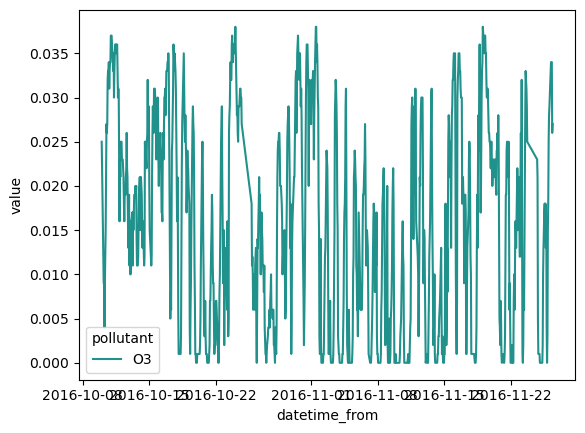

In [222]:
import seaborn as sns

line_plot = sns.lineplot(
    data=o3_df,
    x='datetime_from',
    y='value',
    hue='pollutant',
    palette='viridis' # Use a nice color palette
)

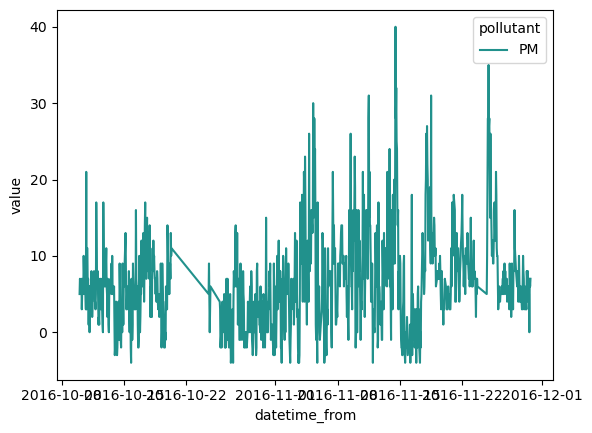

In [221]:
line_plot = sns.lineplot(
    data=pm_df,
    x='datetime_from',
    y='value',
    hue='pollutant',
    palette='viridis' # Use a nice color palette
)

Here's some code to expore a csv of the merged dataset to use in other tools. (Should be very easy to work with in CODAP from here.)

In [ ]:
merged.to_csv("filename.csv")